In [22]:
from langchain_ollama import ChatOllama

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import interrupt
from dotenv import load_dotenv
import os
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from pydantic import BaseModel
from typing import List

from IPython.display import Image, display

In [2]:
load_dotenv()
tavily_api_key = os.getenv("tavily_api_key")

llm = ChatOllama(
    model="granite3.2:8b-instruct-fp16",
    frequency_penalty= 0,
    max_tokens= 100,
    presence_penalty= 0,
    temperature= 0,
    top_p= 1
)

llm.invoke("what is the capital of Iran")

AIMessage(content="The capital of Iran is Tehran. It's the largest city in the country and serves as its political, cultural, commercial, and industrial center.", additional_kwargs={}, response_metadata={'model': 'granite3.2:8b-instruct-fp16', 'created_at': '2025-03-13T16:27:48.3633948Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2693046900, 'load_duration': 29346400, 'prompt_eval_count': 50, 'prompt_eval_duration': 399000000, 'eval_count': 36, 'eval_duration': 2262000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-7736ddd9-efd1-47c7-996e-b1639bf7c7a1-0', usage_metadata={'input_tokens': 50, 'output_tokens': 36, 'total_tokens': 86})

In [23]:
class State(TypedDict):
    function_str: str
    #latex_str:str
    #value: float
    user_message : str
    messages: Annotated[list, add_messages]


def greeting(AgentState:State )-> str:
    template = "you are a value extraction assistant. Greet the user and write a sentence about importance of math in life." \
    "Then ask for a mathematical function that you can evaluate written in a bracket."

    messages  = [SystemMessage(content=template)] + AgentState["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}



def user_enter_function(AgentState: State):
    value = interrupt(
        # Any JSON serializable value to surface to the human.
        # For example, a question or a piece of text or a set of keys in the state
       {"function_str": AgentState["function_str"]})
    
    # Update the state with the human's input or route the graph based on the input.
    return {
        "function_str_entered": value
    }

    





In [25]:
graph_builder = StateGraph(State)
graph_builder.add_node("greeting", greeting)
graph_builder.add_node("user_enter_function", user_enter_function)

graph_builder.set_entry_point("greeting")
graph_builder.add_edge("greeting","user_enter_function")
graph_builder.set_finish_point("user_enter_function")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer = memory)

config = {"configurable":{"thread_id":1}}

In [32]:
def interact_with_agent():
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            print("Ending the conversation.")
            break
        input_message = {
        "messages": [HumanMessage(content=user_input)]
        }
        for chunk in graph.stream(input_message, stream_mode="values",config = config):
            chunk["messages"][-1].pretty_print()


# Start interacting with the agent
interact_with_agent()

================================ Human Message =================================

hi
================================== Ai Message ==================================

Hello Mike! As we've discussed, mathematics is vital in our daily lives, from managing finances to understanding scientific principles.

 Could you please provide me with a mathematical function that I can evaluate? For example, you might say "2 + 3" or "sin(45)". Please write it inside brackets.


KeyError: 'function_str'

In [ ]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message),config = config
        else:
            message.pretty_print()
            

question = "hi. I am mike"
config = {"configurable":{"thread_id":1}}
query ={"messages": [HumanMessage(content=question)]}
print_stream(graph.stream(query, stream_mode="values"))

================================ Human Message =================================

hi. I am mike
================================== Ai Message ==================================

Hello Mike, it's great to meet you! Mathematics plays a crucial role in our daily lives, from simple tasks like budgeting and measuring ingredients while cooking, to complex ones such as engineering and computer programming. It helps us understand patterns, make predictions, and solve problems systematically.

Now, could you please provide me with a mathematical function that I can evaluate? For example, you might say something like "2 + 3" or "sin(45)". Please write it inside brackets.


KeyError: 'function_str'

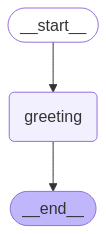

In [8]:
display(graph)

In [ ]:
from typing import Literal
from langgraph.types import interrupt, Command

def human_approval(state: State) -> Command[Literal["some_node", "another_node"]]:
    is_approved = interrupt(
        {
            "question": "Is this correct?",
            # Surface the output that should be
            # reviewed and approved by the human.
            "llm_output": state["llm_output"]
        }
    )

    if is_approved:
        return Command(goto="some_node")
    else:
        return Command(goto="another_node")

# Add the node to the graph in an appropriate location
# and connect it to the relevant nodes.
graph_builder.add_node("human_approval", human_approval)
graph = graph_builder.compile(checkpointer=checkpointer)

# After running the graph and hitting the interrupt, the graph will pause.
# Resume it with either an approval or rejection.
thread_config = {"configurable": {"thread_id": "some_id"}}
graph.invoke(Command(resume=True), config=thread_config)